In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json 
import ipywidgets as wdg


# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [2]:
#function to convert a date string into a pandas datetime object
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

## **COVID DASHBOARD (+influenza)**

In [3]:
#load the data
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("cases.json", "rt") as INFILE:
    cases=json.load(INFILE)
with open("deaths.json", "rt") as INFILE:
    deaths=json.load(INFILE)

with open("influenzaAdmission.json", "rt") as INFILE:
    influenzaAdmissions=json.load(INFILE)   
with open("bedsDay.json", "rt") as INFILE:
    bedsDay=json.load(INFILE)
    
#compare the pcr tests for covid and influenza
with open("CovidPCRlatest.json", "rt") as INFILE:
    CovidPCR=json.load(INFILE)
with open("influenzaPCRlatest.json", "rt") as INFILE:
    influenzaPCR=json.load(INFILE)

#deaths for years
with open("deaths_2022.json", "rt") as INFILE:
    deaths_2022=json.load(INFILE)
with open("deaths_2023.json", "rt") as INFILE:
    deaths_2023=json.load(INFILE)
with open("deaths_2024.json", "rt") as INFILE:
    deaths_2024=json.load(INFILE)


### Automatically converting two jsons to a plot.

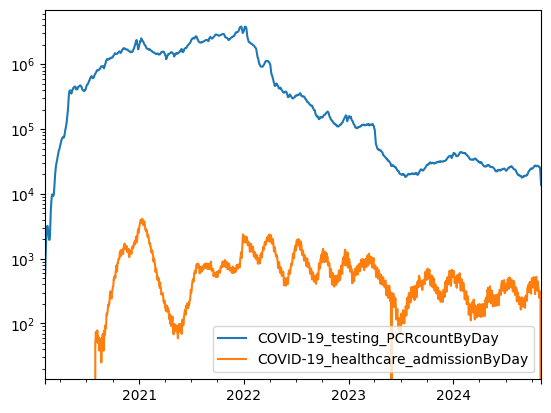

In [4]:


def wrangle_data_two(rawdata, anotherdata):
#create a new dictionary to store the data
    newJson={}
    metricList=[]
    for dataset in [rawdata, anotherdata]:
        for entry in dataset:
            date=entry["date"]
            metric=entry["metric"]
            value =entry["metric_value"]
            if date not in newJson:
                newJson[date]={}
            newJson[date][metric]=value
            if metric not in metricList:
                metricList.append(metric)
    
    #dates
    dates=list(newJson.keys())
    dates.sort()
    
    #convert start and end dates to pandas format for the index data range
    startDate=parse_date(dates[0])
    endDate=parse_date(dates[-1])
    
    
    index = pd.date_range(startDate, endDate, freq='D')
    df=pd.DataFrame(index=index, columns=[metric for metric in metricList])
    metrics ={metric:metric for metric in metricList}
    
    for date, entry in newJson.items(): # each entry is a dictionary with cases, admissions and deaths
        pd_date=parse_date(date) # convert to Pandas format
        for column in [metric for metric in metricList]: # each column is a metric
            metric_name=metrics[column]
            #if a value is not available, insert a 0.0
            value= entry.get(metric_name, 0.0)
            df.loc[date, column]=value
    # fill in any remaining "holes" due to missing dates
    df.fillna(0.0, inplace=True)
    return df

df=wrangle_data_two(CovidPCR, admissions).plot(logy=True) # df is the dataframe for plotting

### Converting one data to a dataframe, with a refresh button that updates the graph with the latest data.

In [5]:
import requests
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return []
        curr_time=time.time() 
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [12]:
def wrangle_data(rawdata):
    #convert the combined data into a pandas dataframe
    newJson={}
    if len(rawdata)==0:
        return {}
    for entry in rawdata:
        date=entry["date"]
        metric=entry["metric"]
        value =entry["metric_value"]
        if date not in newJson:
            newJson[date]={}
        newJson[date][metric]=value
        
    dates=list(newJson.keys())
    dates.sort()

    #convert start and end dates to pandas format for the index data range
    startDate=parse_date(dates[0])
    endDate=parse_date(dates[-1])
    
    metrics ={'Covid': metric}
    
    index = pd.date_range(startDate, endDate, freq='D')
    df=pd.DataFrame(index=index, columns=['Covid'])
    
    for date, entry in newJson.items():
        pd_date=parse_date(date)
        for column in ['Covid']: 
            metric_name=metrics[column]
            value= entry.get(metric_name, 0.0)
            df.loc[date, column]=value
    df.fillna(0.0, inplace=True)
    return df

In [7]:
def access_api( topic, metric):
       try:
              structure={"theme": "infectious_disease", 
                     "sub_theme": "respiratory",
                     "topic": topic,
                     "geography_type": "Nation", 
                     "geography": "England"}
              structure["metric"]=metric 
              api=APIwrapper(**structure)
              data=api.get_all_pages()
              print(data)
              return data # return data read from the API
       except:
           print("Error in accessing the API")


In [13]:
# This will be called by the button when it is clicked
covidDf = wrangle_data(cases)

def api_button_callback(button):
    try:
        apidata = access_api('COVID-19', 'COVID-19_cases_casesByDay')
        global covidDf
        covidDf=wrangle_data(apidata)
        apibutton.icon="check"
        apibutton.button_style="success"
    except:
        apibutton.icon="exclamation-triangle"
        apibutton.button_style="danger"
        apibutton.description="Error in API"
        print("Error in accessing the API")
    
 
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='info',
    tooltip='Click to refresh and update the graph',
    icon='download' 
)

covidDf = wrangle_data(cases)
apibutton.on_click(api_button_callback) # the name of the function we defined earlier


Button(button_style='info', description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click t…

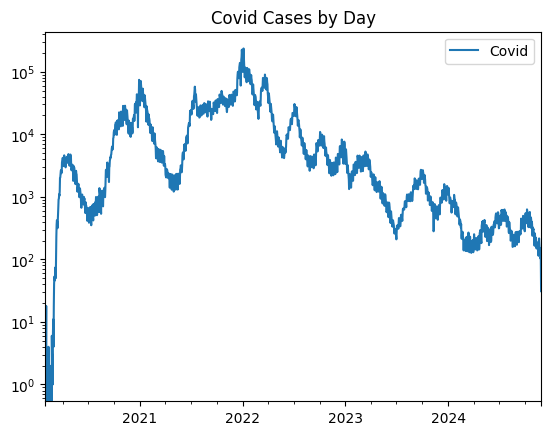

In [11]:

newDf = covidDf.plot(logy=True)
newDf.set_title('Covid Cases by Day')

display(apibutton)

### Look and compare the different years of deaths caused by COVID-19.

In [ ]:
pickGraph=wdg.RadioButtons(
    options=['2022', '2023', '2024'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Pick A Year:',
    disabled=False
)

radio_controls=wdg.VBox([pickGraph])

def radioGraph(graph):
    if graph=='2022':
        newDf = wrangle_data(deaths_2022).plot(logy=True)# df is the dataframe for plotting
        newDf.set_title('Deaths in 2022')
        newDf.set_ylabel('Number of deaths(log(n))')
        newDf.set_xlabel('Year')
        plt.show()
    elif graph=='2023':
        newDf = wrangle_data(deaths_2023).plot(logy=True)
        newDf.set_title('Number of Deaths in 2023')
        newDf.set_ylabel('Number of deaths (log(n))')
        newDf.set_xlabel('Year')
        plt.show()
    elif graph=='2024':
        newDf = wrangle_data(deaths_2024).plot(logy=True)
        newDf.set_title('Number of Deaths in 2024')
        newDf.set_ylabel('Number of death in log(n)')
        newDf.set_xlabel('Year')
        plt.show()
    else:
        print('Invalid selection')

pick_graph=wdg.interactive(radioGraph, graph=pickGraph)

display(pick_graph)


interactive(children=(RadioButtons(description='Pick A Year:', options=('2022', '2023', '2024'), value='2022')…

### Compare all the data from Covid cases, deaths, addmissions, beds occupied, and similarly for influenza.

In [ ]:
# in the dashboard, this should be computed from the json files
alldatadfpk=pd.read_pickle("allData.pkl")

series=wdg.SelectMultiple(
    options=['cases', 'admissions', 'deaths', 'influenzaAdmissions', 'bedsDay','CovidPCR', 'influenzaPCR'],
    value=['cases', 'admissions', 'deaths', 'influenzaAdmissions', 'bedsDay','CovidPCR', 'influenzaPCR'],
    rows=2,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        alldatadfpk[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()

Compare the trend between covid cases and how many covid patients are in the hospital.

In [ ]:
#covid cases by day and beds
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("covidDayBeds.pkl")

series=wdg.SelectMultiple(
    options=['beds', 'covidCases'],
    value=['beds', 'covidCases'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
 
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()